# **Abandono de carrera por estudiantes mediante implementación de clasificación con Keras y CNN**

Asignatura: INF495 - Introducción a las Redes Neuronales y Deep Learning.

Integrantes:
* Bruno Morici - ROL: 202373555-8
* Juan Pablo Fuenzalida - ROL: 202375peneshit-pene
* Tutor: Alejandro Veloz


Usando el dataset de la UCL Machine Learning "Students' Dropout and Academic Success Dataset". Acceder mediante el siguiente link : https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

## Importación e instalación de librerias necesarias

In [1]:
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install tensorflow keras-tuner
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import zscore
from ucimlrepo import fetch_ucirepo 

C:\Users\JP\AppData\Local\Temp\ipykernel_6524\2717806785.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Limpieza y carga del Dataset

In [3]:
# Cargar el dataset (por ID)
dataset = fetch_ucirepo(id=697)

# Acceder a los datos como DataFrame de pandas
df = dataset.data.features
target = dataset.data.targets

# Unirlos si quieres un solo DataFrame
df = pd.concat([df, target], axis=1)

# Mostrar las primeras filas
df.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


**Información del dataset:**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

**Revisando si existen valores nulos en el dataset:**

In [5]:
df.isna().sum()

Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

**Convertimos los nombres de las columnas a minúsculas para facilitar su manejo:**

In [6]:
df.columns = [col.replace(' ','_').replace("'s",'').replace('\t','').replace('/','_').replace('(','').replace(')','').lower() for col in df.columns]
df.columns

Index(['marital_status', 'application_mode', 'application_order', 'course',
       'daytime_evening_attendance', 'previous_qualification',
       'previous_qualification_grade', 'nacionality', 'mother_qualification',
       'father_qualification', 'mother_occupation', 'father_occupation',
       'admission_grade', 'displaced', 'educational_special_needs', 'debtor',
       'tuition_fees_up_to_date', 'gender', 'scholarship_holder',
       'age_at_enrollment', 'international',
       'curricular_units_1st_sem_credited',
       'curricular_units_1st_sem_enrolled',
       'curricular_units_1st_sem_evaluations',
       'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade',
       'curricular_units_1st_sem_without_evaluations',
       'curricular_units_2nd_sem_credited',
       'curricular_units_2nd_sem_enrolled',
       'curricular_units_2nd_sem_evaluations',
       'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade',
       'curricular_units_2nd_sem_without

Explicación para cada columna de la tabla:

| Columna                                        | Significado                                                                                                                 |
| ---------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| `marital_status`                               | Estado civil del alumno/a al momento de la inscripción.                                                                     |
| `application_mode`                             | Modo de aplicación al curso (por ejemplo, presencial vs. en línea, u otra categoría).                                       |
| `application_order`                            | Orden de la solicitud de ingreso (por ejemplo, cuántas aplicaciones realizó antes, o prioridad de la solicitud).            |
| `course`                                       | Código o identificador del curso al que se inscribió el estudiante.                                                         |
| `daytime_evening_attendance`                   | Asistencia: diurna o vespertina (día vs. noche) para el curso.                                                              |
| `previous_qualification`                       | Tipo de cualificación/título anterior que tenía el estudiante antes de este nivel educativo.                                |
| `previous_qualification_grade`                 | Nota o calificación obtenida en la cualificación anterior.                                                                  |
| `nacionality`                                  | Nacionalidad del estudiante.                                                                                                |
| `mother_qualification`                         | Nivel de formación de la madre del estudiante.                                                                              |
| `father_qualification`                         | Nivel de formación del padre del estudiante.                                                                                |
| `mother_occupation`                            | Ocupación laboral de la madre del estudiante.                                                                               |
| `father_occupation`                            | Ocupación laboral del padre del estudiante.                                                                                 |
| `admission_grade`                              | Nota de admisión al curso/universidad del estudiante.                                                                       |
| `displaced`                                    | Si el estudiante es desplazado (por ejemplo, geográfica o socialmente) o no.                                                |
| `educational_special_needs`                    | Si el estudiante tiene necesidades educativas especiales.                                                                   |
| `debtor`                                       | Si el estudiante adeuda pagos (por ejemplo, matrícula u otros cargos) o no.                                                 |
| `tuition_fees_up_to_date`                      | Si las tasas de matrícula están al día o no.                                                                                |
| `gender`                                       | Género del estudiante.                                                                                                      |
| `scholarship_holder`                           | Si el estudiante tiene una beca o no.                                                                                       |
| `age_at_enrollment`                            | Edad del estudiante al momento de la inscripción.                                                                           |
| `international`                                | Si el estudiante es internacional (extranjero) o no.                                                                        |
| `curricular_units_1st_sem_credited`            | Unidades curriculares acreditadas en el primer semestre.                                                                    |
| `curricular_units_1st_sem_enrolled`            | Unidades curriculares en que se matriculó el estudiante en el primer semestre.                                              |
| `curricular_units_1st_sem_evaluations`         | Número de unidades curriculares que fueron evaluadas en el primer semestre.                                                 |
| `curricular_units_1st_sem_approved`            | Unidades curriculares aprobadas en el primer semestre.                                                                      |
| `curricular_units_1st_sem_grade`               | Nota promedio o de alguna unidad en el primer semestre (o quizá nota global del semestre).                                  |
| `curricular_units_1st_sem_without_evaluations` | Unidades curriculares del primer semestre sin evaluación (por ejemplo exentas u otro motivo).                               |
| `curricular_units_2nd_sem_credited`            | Unidades curriculares acreditadas en el segundo semestre.                                                                   |
| `curricular_units_2nd_sem_enrolled`            | Unidades curriculares en que se matriculó el estudiante en el segundo semestre.                                             |
| `curricular_units_2nd_sem_evaluations`         | Número de unidades curriculares que fueron evaluadas en el segundo semestre.                                                |
| `curricular_units_2nd_sem_approved`            | Unidades curriculares aprobadas en el segundo semestre.                                                                     |
| `curricular_units_2nd_sem_grade`               | Nota promedio o de alguna unidad en el segundo semestre (o nota global).                                                    |
| `curricular_units_2nd_sem_without_evaluations` | Unidades curriculares del segundo semestre sin evaluación.                                                                  |
| `unemployment_rate`                            | Tasa de desempleo correspondiente al contexto económico del estudiante (o región) en el momento.                            |
| `inflation_rate`                               | Tasa de inflación correspondiente al contexto económico del estudiante (o región) en el momento.                            |
| `gdp`                                          | Producto interno bruto (PIB) correspondiente al contexto económico del estudiante (o región) en el momento.                 |
| `target`                                       | Si el estudiante abandonó, se graduó o sigue cursando en la actualidad. |


**Análisis Exploratorio de datos**

In [7]:
df.describe()

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nacionality,mother_qualification,father_qualification,...,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


**Eliminamos Outliers con el método de Z-Score**

In [8]:
threshold = 3

z_scores = zscore(df.select_dtypes(include=[np.number]))
outliers = (np.abs(z_scores) > threshold).any(axis=1)
df_2 = df[~outliers].copy()

print(f"Se eliminaron { len(df) - len(df_2) } filas del dataset")
df_2

Se eliminaron 1343 filas del dataset


,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nacionality,mother_qualification,father_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
6,1,1,1,9500,1,1,142.0,1,19,38,...,0,8,8,8,14.345000,0,15.5,2.8,-4.06,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,1,1,1,9070,1,1,124.0,1,37,19,...,1,6,9,5,12.500000,0,10.8,1.4,1.74,Graduate
4412,1,43,1,9070,1,1,125.0,1,19,19,...,2,6,7,5,12.200000,0,13.9,-0.3,0.79,Enrolled
4414,1,1,1,9130,1,1,137.0,1,3,38,...,0,5,8,5,11.600000,0,9.4,-0.8,-3.12,Graduate
4417,1,1,1,9070,1,1,132.0,1,1,1,...,0,6,6,6,13.500000,0,16.2,0.3,-0.92,Graduate


**Verificamos que no haya desbalanceo de clases**

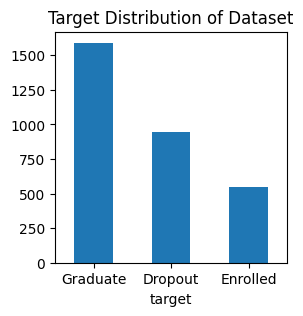

In [9]:
df_2['target'].value_counts()
df_2["target"].value_counts().plot(kind="bar", figsize=(3,3), title="Target Distribution of Dataset")
plt.xticks(rotation=0)
plt.show()

Como existe desbalanceo de clases, usaremos el método de **Balanceo Artificial por vía de Modificación de Función Objetivo** para las muestras que sean de las clases "Dropout" y "Enrolled"

## Separación del dataset en entrenamiento y testing

**Split X, y**

In [10]:
class_names, y = np.unique(df_2['target'], return_inverse=True)
print(y)
print(class_names)
X = df_2.drop('target', axis=1)

[2 0 2 ... 2 2 0]
['Dropout' 'Enrolled' 'Graduate']


**One Hot Encoding**

In [11]:
one_hot_cols = ['marital_status',
                'daytime_evening_attendance',
                'tuition_fees_up_to_date',
                'educational_special_needs',
                'displaced',
                'scholarship_holder',
                'gender',
                'debtor',
                'international',
                ]

for i in one_hot_cols:
    X[i] = X[i].apply(lambda x: float(x))
    X[i] = X[i].apply(lambda x: int(x))

for i in one_hot_cols:
    dum = pd.get_dummies(X[i], prefix=i)
    X.drop([i], axis=1, inplace=True)
    X = pd.concat([X, dum], axis=1)

**Dividimos el Dataset en entrenamiento y testing**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train_corr = X_train.copy()
X_train_corr['target'] = y_train

**Mapa de correlación de la variable target en base a las diferentes columnas de el Dataset**

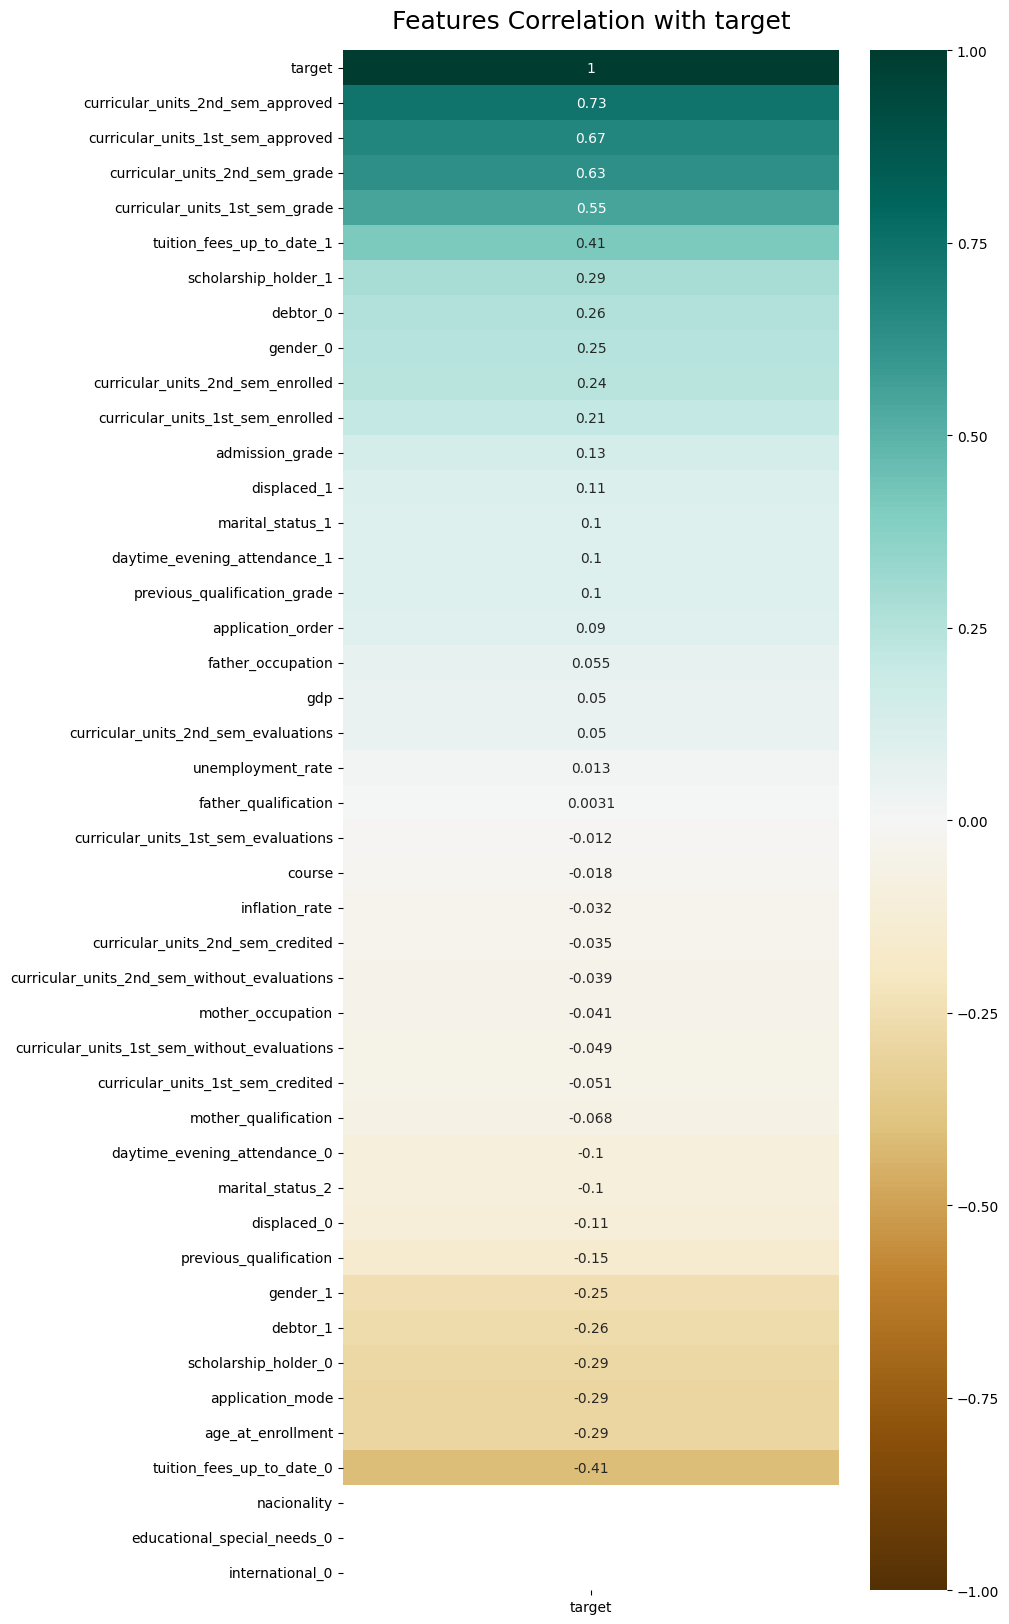

In [13]:
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(X_train_corr.corr()[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlation with target', fontdict={'fontsize':18}, pad=16);

**Seleccionamos las features que deseamos analizar.**

In [14]:
features_list = ['curricular_units_2nd_sem_approved',
                 'curricular_units_1st_sem_approved',
                 'curricular_units_2nd_sem_grade',
                 'curricular_units_1st_sem_grade',
                 'tuition_fees_up_to_date_1',
                 'scholarship_holder_1',
                 'debtor_0',
                 'gender_0',
                 'curricular_units_2nd_sem_enrolled',
                 'curricular_units_1st_sem_enrolled',
                 'tuition_fees_up_to_date_0',
                 'age_at_enrollment',
                 'application_mode',
                 'scholarship_holder_0',
                 'debtor_1',
                 'gender_1']

**Recortamos el entrenamiento y testing a esas features**

In [15]:
X_train_fs = X_train[features_list]
X_test_fs = X_test[features_list]

**Normalizamos de forma estándar los datos, con el fin de no darle más relevancia al número por su tamaño en sí, si no que por su impacto respecto a los otros datos**

In [16]:
scaler = StandardScaler()
scaler.fit(X_train_fs)

X_train_sc = scaler.transform(X_train_fs)
X_test_sc = scaler.transform(X_test_fs)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_fs.columns)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_fs.columns)

**Aplicamos PCA para disminuir la complejidad del modelo**

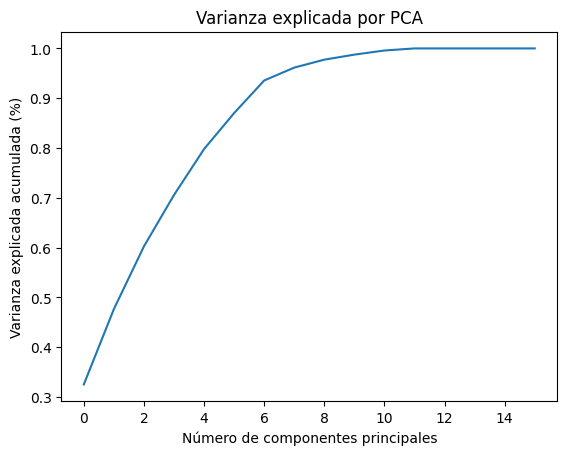

In [17]:
# Ajustar el modelo PCA a los datos de entrenamiento ya escalados
pca = PCA().fit(X_train_sc)

# Crear una figura y graficar la varianza acumulada explicada por los componentes principales
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada (%)')
plt.title('Varianza explicada por PCA')
plt.show()

In [18]:
num_pca = 16
pca = PCA(n_components=num_pca, whiten=True).fit(X_train_sc)
X_train_pc = pca.transform(X_train_sc)
X_test_pc = pca.transform(X_test_sc)

**Balanceamos mediante modificación de la Función Objetivo, haciendo variar los pesos**

In [19]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{np.int64(0): np.float64(1.0893015030946065),
 np.int64(1): np.float64(1.837434750186428),
 np.int64(2): np.float64(0.6503035101609923)}

## Modelo de predicción

**Usaremos el Tuner de Keras para encontrar el mejor modelo y utilizar ese**

In [20]:
def build_model(hp):
    # Se define una función que crea un modelo de red neuronal.
    # 'hp' (HyperParameters) es un objeto de Keras Tuner que permite ajustar
    # dinámicamente los valores de hiperparámetros como número de capas, neuronas, etc.

    model = Sequential()  # Modelo secuencial: las capas se apilan una tras otra.

    # Capa de entrada: aplana los datos de entrada de tamaño 16 a un vector 1D.
    model.add(Flatten(input_shape=(16, )))

    # Bucle para crear entre 1 y 10 capas ocultas, determinado por el hiperparámetro.
    for i in range(hp.Int('num_layers', 1, 10)):
        # Regularización L1 y L2, con valores elegidos logarítmicamente entre 1e-5 y 1e-2.
        # Esto ayuda a prevenir el sobreajuste penalizando pesos grandes.
        reg = l1_l2(
            l1=hp.Float('l1_' + str(i), min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_' + str(i), min_value=1e-5, max_value=1e-2, sampling='log')
        )

        # Capa densa (completamente conectada)
        # - Número de neuronas: entre 2 y 100, en pasos de 2.
        # - Función de activación: elegida entre 'relu', 'tanh' o 'sigmoid'.
        # - Regularización aplicada mediante l1_l2.
        model.add(Dense(
            hp.Int('units_' + str(i), min_value=2, max_value=100, step=2),
            activation=hp.Choice('activation_' + str(i),
                                 values=['relu', 'tanh', 'sigmoid']),
            kernel_regularizer=reg
        ))

        # Capa de Dropout: apaga aleatoriamente una fracción de neuronas durante el entrenamiento
        # para reducir el sobreajuste.
        model.add(Dropout(
            hp.Choice('dropout_' + str(i),
                      values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
        ))

    # Capa de salida con 3 neuronas (una por clase de salida)
    # y activación softmax (para clasificación multiclase).
    model.add(Dense(3, activation='softmax'))

    # Compilación del modelo:
    # - Optimizador: Adam
    # - Pérdida: entropía cruzada (para etiquetas enteras)
    # - Métrica: precisión
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model  # Retorna el modelo construido para que el tuner lo entrene y evalúe.


In [21]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=5,
    project_name='hyper_tuning'
)
""" Usar para ejecuciones serias
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=200,
    executions_per_trial=100,
    project_name='hyper_tuning'
)
"""

earlys = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

tuner.search(
    X_train_pc, y_train,
    epochs=20,                 
    class_weight=class_weights,
    verbose=1,
    validation_data=(X_test_pc, y_test)
)
""" Usar para ejecuciones serias
tuner.search(
    X_train_pc, y_train,
    epochs=100,                 
    class_weight=class_weights,
    verbose=1,
    validation_data=(X_test_pc, y_test)
)
"""

Reloading Tuner from .\hyper_tuning\tuner0.json


' Usar para ejecuciones serias\ntuner.search(\n    X_train_pc, y_train,\n    epochs=100,                 \n    class_weight=class_weights,\n    verbose=1,\n    validation_data=(X_test_pc, y_test)\n)\n'

In [22]:
tuner.results_summary()

Results summary
Results in .\hyper_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
num_layers: 1
l1_0: 4.339803254975237e-05
l2_0: 0.0072037878925137605
units_0: 58
activation_0: relu
dropout_0: 0.9
l1_1: 0.0004529161954867857
l2_1: 0.0010771758326996133
units_1: 64
activation_1: tanh
dropout_1: 0.7
l1_2: 1.1209098133153222e-05
l2_2: 2.1080415469627927e-05
units_2: 2
activation_2: tanh
dropout_2: 0.3
l1_3: 6.300805075826862e-05
l2_3: 0.0018345045241281246
units_3: 24
activation_3: relu
dropout_3: 0.9
l1_4: 0.0041334837002612364
l2_4: 0.0019117663701453092
units_4: 50
activation_4: relu
dropout_4: 0.1
l1_5: 0.0016276988138216682
l2_5: 0.00401340218813401
units_5: 16
activation_5: sigmoid
dropout_5: 0.7
l1_6: 3.405543195799205e-05
l2_6: 0.00011910899030388787
units_6: 36
activation_6: relu
dropout_6: 0.1
l1_7: 0.0008934007051035219
l2_7: 0.0010050435008113368
units_7: 24
activation_7: sigmoid
dropout_7: 0.6
l1_8: 0.00963032

In [23]:
models = tuner.get_best_models(num_models=10)
if len(models) == 0:
    print("No se encontraron modelos válidos. Revisa los resultados del tuner.")
else:
    best_model = models[0]
    best_model.summary()

c:\Users\JP\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\JP\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\JP\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\JP\AppData\Local\Programs\Python\Python313\Lib\site-packages\k

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 58)             │           986 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 58)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           177 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,163 (4.54 KB)

 Trainable params: 1,163 (4.54 KB)

 Non-trainable params: 0 (0.00 B)

**Hacemos un fit con el modelo en cuestión**

Epoch 1/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6818 - loss: 0.9407 - val_accuracy: 0.7861 - val_loss: 0.8015
Epoch 2/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6851 - loss: 0.9408 - val_accuracy: 0.7844 - val_loss: 0.7980
Epoch 3/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6843 - loss: 0.9213 - val_accuracy: 0.7861 - val_loss: 0.7840
Epoch 4/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6818 - loss: 0.9236 - val_accuracy: 0.7844 - val_loss: 0.7789
Epoch 5/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6972 - loss: 0.9036 - val_accuracy: 0.7909 - val_loss: 0.7679
Epoch 6/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6968 - loss: 0.8951 - val_accuracy: 0.7861 - val_loss: 0.7574
Epoch 7/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7086 - loss: 0.8838 - val_accuracy: 0.7812 - val_loss: 0.7517
Epoch 8/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6993 - loss: 0.8798 - val_accuracy: 0.7893 - v

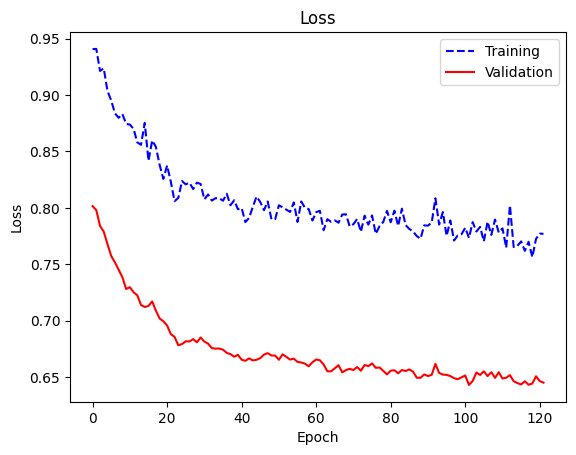

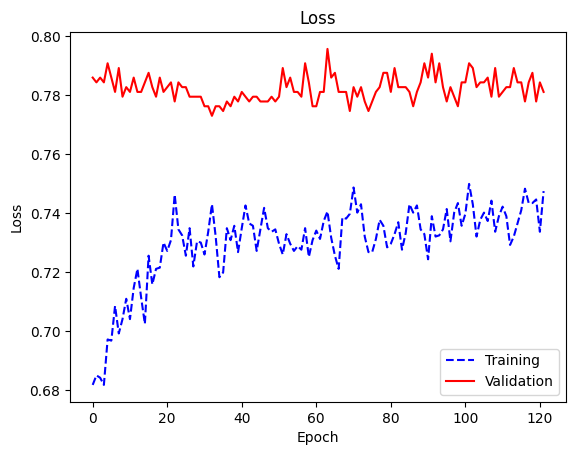

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

     Dropout       0.91      0.72      0.80       190
    Enrolled       0.44      0.57      0.50        99
    Graduate       0.85      0.88      0.87       328

    accuracy                           0.78       617
   macro avg       0.73      0.72      0.72       617
weighted avg       0.80      0.78      0.79       617



In [24]:
history = best_model.fit(
    X_train_pc, y_train,
    epochs=500,
    batch_size=64,
    class_weight=class_weights,
    verbose=1,
    validation_data=(X_test_pc, y_test),
    callbacks=[earlys]
)

score = best_model.evaluate(X_test_pc, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

df_hist = pd.DataFrame.from_dict(history.history)
df_hist['loss'].plot(style='b--', label='Training')
df_hist['val_loss'].plot(style='r-', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

df_hist['accuracy'].plot(style='b--', label='Training')
df_hist['val_accuracy'].plot(style='r-', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

y_pred = best_model.predict(X_test_pc)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_labels, target_names=class_names))

**Pequeño ejemplo de aplicacion del Modelo**

In [27]:
def predict_student(student_data, model, scaler, pca, class_names):
    """
    student_data: dict con los datos del estudiante, las mismas columnas que X_train_fs
    model: modelo entrenado (best_model)
    scaler: objeto StandardScaler usado para normalizar los datos
    pca: objeto PCA usado para reducir dimensiones
    class_names: lista de nombres de clases ['Dropout', 'Enrolled', 'Graduate']
    """
    
    # Convertir el dict a DataFrame
    df = pd.DataFrame([student_data])
    
    # Asegurarse de tener todas las columnas de entrenamiento
    missing_cols = set(X_train_fs.columns) - set(df.columns)
    for col in missing_cols:
        df[col] = 0  # rellenar con 0 si falta alguna columna
    
    # Ordenar columnas igual que X_train_fs
    df = df[X_train_fs.columns]
    
    # Escalar
    df_scaled = scaler.transform(df)
    
    # PCA
    df_pc = pca.transform(df_scaled)
    
    # Predecir
    pred_probs = model.predict(df_pc)
    pred_class = np.argmax(pred_probs, axis=1)[0]
    
    return class_names[pred_class]

student = {
    'curricular_units_2nd_sem_approved': 5,
    'curricular_units_1st_sem_approved': 6,
    'curricular_units_2nd_sem_grade': 12.5,
    'curricular_units_1st_sem_grade': 13.0,
    'tuition_fees_up_to_date_1': 1,
    'scholarship_holder_1': 0,
    'debtor_0': 1,
    'gender_0': 1,
    'curricular_units_2nd_sem_enrolled': 6,
    'curricular_units_1st_sem_enrolled': 6,
    'tuition_fees_up_to_date_0': 0,
    'age_at_enrollment': 20,
    'application_mode': 1,
    'scholarship_holder_0': 1,
    'debtor_1': 0,
    'gender_1': 0
}

resultado = predict_student(student, best_model, scaler, pca, class_names)
print(f"Predicción del estudiante: {resultado}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicción del estudiante: Graduate


c:\Users\JP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
